# Lab 3: MB in OOD settings

[Nastl et al.](https://proceedings.neurips.cc/paper_files/paper/2024/file/3792ddbf94b68ff4369f510f7a3e1777-Paper-Conference.pdf) shows 
that models using all features consistently outperform causal features. 

These empirical results challenge the practical value of causal features.

However, from our previous labs (Lab 1 and 2), we have shown that Markov Blanket is the **optimal** feature set under IID conditions.

This apparent contradiction leads to the central question for Lab 3:

<center>Is the MB still the optimal feature set in OOD setting?</center>

In [1]:
%load_ext watermark
%watermark -a "Shu Wan" -v

%load_ext autoreload
%autoreload 2

Author: Shu Wan

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.6.0



In [2]:
import logging
logging.disable(logging.WARNING)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars
from dotenv import load_dotenv

from blanket.datasets import load_data
from blanket.graph import get_markov_blanket, get_parents, get_children, get_spouses
from blanket.plots import plot_graph, plot_distributions
from blanket.models import linear_regression

load_dotenv()
disable_progress_bars()
plt.rcParams['figure.dpi'] = 100


## 1. Load Dataset from HuggingFace

In this section, we load the phase3 dataset from HuggingFace, which contains multiple datasets with different environment configurations (IID, covariate shift, and label shift).


In [3]:
# Download the dataset from HuggingFace
path_to_data = snapshot_download(
    repo_id="CSE472-blanket-challenge/phase3-dataset",
    repo_type="dataset",
)
# path_to_data = LOCAL_PATH # Uncomment this line to use local data
print(f"Dataset downloaded to: {path_to_data}")


Dataset downloaded to: /Users/sahajpreetsinghkhasria/.cache/huggingface/hub/datasets--CSE472-blanket-challenge--phase3-dataset/snapshots/129d3ba8e7fcaa8e6c018e6ea0bf9a2ee647babe


In [4]:
# Load metadata
metadata_ds = load_dataset(path_to_data, split='train')
print(f"Total datasets available: {len(metadata_ds)}")
print(f"\nMetadata fields: {metadata_ds.column_names}")

Total datasets available: 120

Metadata fields: ['data_id', 'graph_id', 'target_idx', 'dataset_idx', 'n_train', 'n_test', 'n_features', 'adjacency_matrix', 'feature_mask', 'selection_method', 'parents', 'children', 'spouses', 'scm', 'environment', 'graph_meta']


In [5]:
# Examine the distribution of environment types
env_methods = [entry['environment']['method'] for entry in metadata_ds]
env_counts = pd.Series(env_methods).value_counts()
print("\nEnvironment distribution:")
env_counts



Environment distribution:


label        40
covariate    40
iid          40
Name: count, dtype: int64

In [6]:
# Load a specific dataset to verify I/O
example_data_id = metadata_ds[0]['data_id']
print(f"Loading dataset: {example_data_id}")

X_train, y_train, X_test, y_test, metadata = load_data(
    path_to_data,
    data_id=example_data_id,
    include_metadata=True
)

print(f"\nTrain shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test shape: X={X_test.shape}, y={y_test.shape}")
print(f"\nMetadata keys: {list(metadata.keys())}")
print(f"SCM: {metadata['scm']}")
print(f"Environment: {metadata['environment']}")
print(f"Graph Metadata: {metadata['graph_meta']}")

Loading dataset: data_01475249

Train shape: X=(800, 9), y=(800,)
Test shape: X=(200, 9), y=(200,)

Metadata keys: ['data_id', 'graph_id', 'target_idx', 'dataset_idx', 'n_train', 'n_test', 'n_features', 'adjacency_matrix', 'feature_mask', 'selection_method', 'parents', 'children', 'spouses', 'scm', 'environment', 'graph_meta']
SCM: {'functional': 'nonlinear', 'coeff_range': 1.0, 'noise_std': 0.5, 'seed': 58}
Environment: {'method': 'label', 'shift_mean': 0.8, 'shift_std': 0.2, 'train_fraction': 0.8, 'projection': None}
Graph Metadata: {'num_nodes': 10, 'num_edges': 24, 'density': 0.2666666806, 'generation_method': 'PA'}


In [7]:
# Filter datasets
# criteria: has parents, children, not all features are in mb, linear functional
datasets = {}
example_meta = metadata_ds.filter(lambda x: sum(x['parents']) > 0 and sum(x['children']) > 0 and x['scm']['functional'] == 'linear' and sum(x['feature_mask']) < x['n_features'])

for idx, data_id in enumerate(example_meta['data_id']):
    X_tr, y_tr, X_te, y_te, meta = load_data(path_to_data, data_id=data_id, include_metadata=True)
    shift = meta['environment']['method']
    key = f"{shift}-{idx}"
    datasets[key] = {
        'X_train': X_tr, 'y_train': y_tr,
        'X_test': X_te, 'y_test': y_te,
        'metadata': meta
    }

print("Datasets loaded successfully!")

Datasets loaded successfully!


## 2. IID vs OOD: Understanding the Difference

### IID (Independent and Identically Distributed):
- Training and test data are drawn from the same distribution
- $P_{\text{train}}(X, Y) = P_{\text{test}}(X, Y)$
- Standard assumption in machine learning

### Covariate Shift (OOD)
- The distribution of input features changes: $P_{\text{train}}(X) \neq P_{\text{test}}(X)$
- The conditional distribution remains the same: $P_{\text{train}}(Y|X) = P_{\text{test}}(Y|X)$

### Label Shift (OOD)
- The distribution of the target changes: $P_{\text{train}}(Y) \neq P_{\text{test}}(Y)$
- The conditional distribution $P(X|Y)$ remains the same: $P_{\text{train}}(X|Y) = P_{\text{test}}(X|Y)$

Let's visualize the difference by comparing datasets with different environment types.


In [8]:
iid_index = [i for i, key in enumerate(datasets.keys()) if key.split('-')[0] == 'iid']
covariate_index = [i for i, key in enumerate(datasets.keys()) if key.split('-')[0] == 'covariate']
label_index = [i for i, key in enumerate(datasets.keys()) if key.split('-')[0] == 'label']

In [9]:
example_datasets = {
    'iid': datasets[f'iid-{iid_index[0]}'],
    'covariate': datasets[f'covariate-{covariate_index[0]}'],
    'label': datasets[f'label-{label_index[0]}']
}

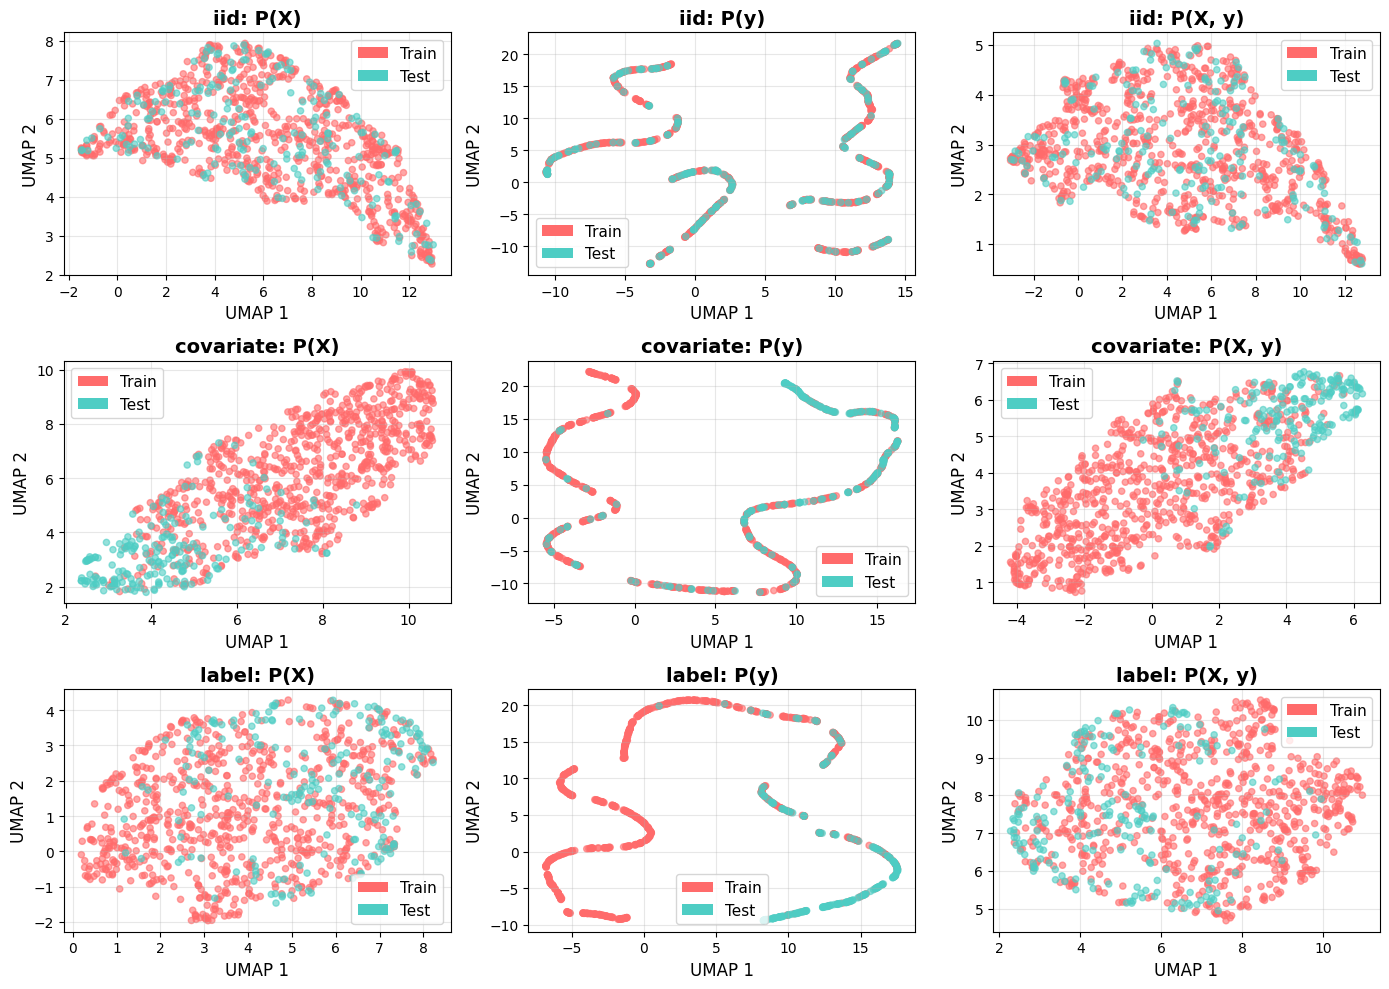

In [10]:
# Visualize distribution differences
fig, axes = plt.subplots(3, 3, figsize=(14, 10))

for i, (name, data) in enumerate(example_datasets.items()):
    # Plot feature distribution
    plot_distributions(
        data['X_train'],
        data['X_test'],
        labels=('Train', 'Test'),
        ax=axes[i, 0],
        title=f"{name}: P(X)"
    )

    # Plot target distribution
    plot_distributions(
        data['y_train'].reshape(-1, 1),
        data['y_test'].reshape(-1, 1),
        labels=('Train', 'Test'),
        ax=axes[i, 1],
        title=f"{name}: P(y)"
    )

    # Plot joint distribution
    plot_distributions(
        np.hstack([data['X_train'], data['y_train'].reshape(-1, 1)]),
        np.hstack([data['X_test'], data['y_test'].reshape(-1, 1)]),
        labels=('Train', 'Test'),
        ax=axes[i, 2],
        title=f"{name}: P(X, y)"
    )

plt.tight_layout()
plt.show()


In [11]:
# Quantify distribution differences using KS statistic
from scipy.stats import ks_2samp

for name, data in example_datasets.items():
    print(f"\n{name}:")

    # KS test for features (average over all features)
    feature_ks = []
    for j in range(data['X_train'].shape[1]):
        ks_stat, _ = ks_2samp(data['X_train'][:, j], data['X_test'][:, j])
        feature_ks.append(ks_stat)

    # KS test for target
    target_ks, _ = ks_2samp(data['y_train'], data['y_test'])

    print(f"  Average Feature KS statistic: {np.mean(feature_ks):.4f}")
    print(f"  Target KS statistic: {target_ks:.4f}")



iid:
  Average Feature KS statistic: 0.0600
  Target KS statistic: 0.0788

covariate:
  Average Feature KS statistic: 0.2764
  Target KS statistic: 0.4925

label:
  Average Feature KS statistic: 0.2469
  Target KS statistic: 0.7412


In [12]:
# Visualize a DAG showing different feature types
# Using one of our datasets
example_name = 'covariate'
example_data = example_datasets[example_name]
adj_matrix = np.asarray(example_data['metadata']['adjacency_matrix'])

print(f"Number of nodes: {adj_matrix.shape[0]}")

parents = get_parents(adj_matrix)
children = get_children(adj_matrix)
spouses = get_spouses(adj_matrix)
mb_mask = example_data['metadata']['feature_mask']

print(f"\nParents: {np.where(parents)[0].tolist()}")
print(f"Children: {np.where(children)[0].tolist()}")
print(f"Spouses: {np.where(spouses)[0].tolist()}")
print(f"Markov Blanket: {np.where(mb_mask)[0].tolist()}")


Number of nodes: 20

Parents: [2, 3, 5, 7, 11, 12, 15, 18]
Children: [1, 8]
Spouses: [0, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17]
Markov Blanket: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18]


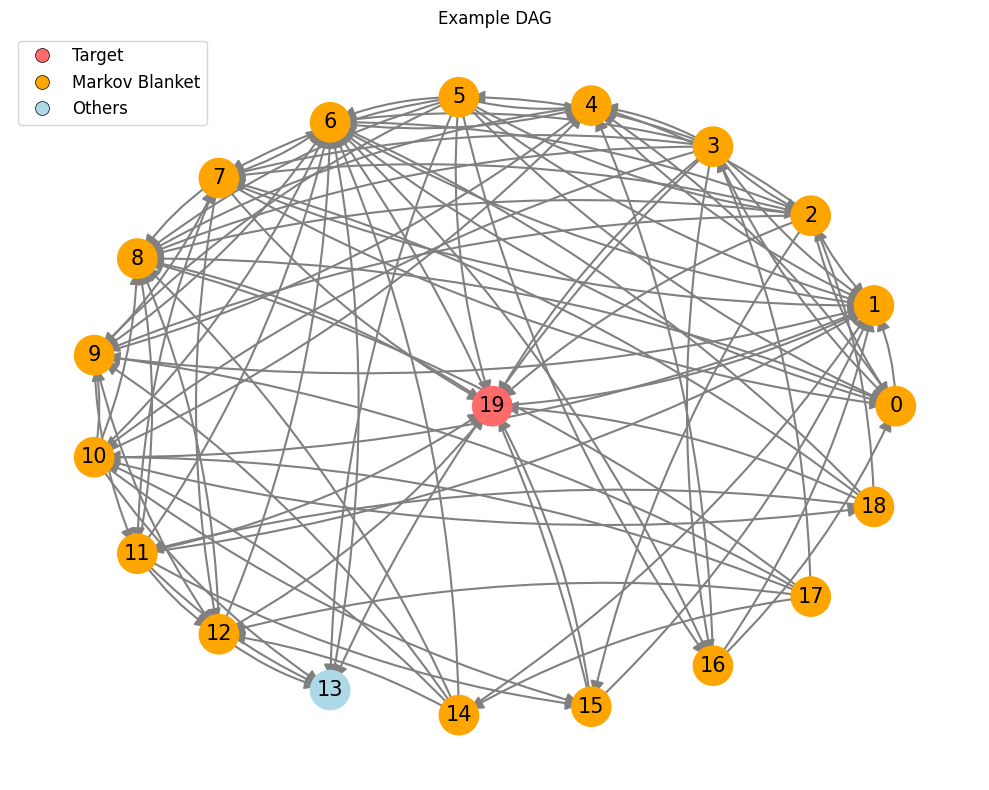

In [13]:
# Visualize the DAG
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_graph(adj_matrix, ax=ax)
ax.set_title(f'Example DAG')
plt.tight_layout()
plt.show()


## 3. Optimality of Markov Blanket in OOD setting


We consider the following feature sets:

1. All Features
2. Markov Blanket
3. Parents (causal)
4. Children (anticausal)
5. P + C
6. Children + Spouses

These feature sets are tested across:
- Three environment types: IID, Covariate Shift, Label Shift
- Varying training sizes: 50 to 800, every 50 as a step
- Evaluation metric: Test MAE and STD (bias and variance)

Expected Outcome

- Nastl et al. show that all features outperforms parents and children consistently and by a large margin.


In [14]:
def get_feature_sets(adj_matrix):
    """Get different feature selection masks."""
    n_features = adj_matrix.shape[0]
    feature_sets = {}

    feature_sets['All'] = np.ones(n_features, dtype=int)
    feature_sets['MB'] = get_markov_blanket(adj_matrix, -1)
    feature_sets['Parents'] = get_parents(adj_matrix, -1)
    feature_sets['Children'] = get_children(adj_matrix, -1)
    feature_sets['Parents+Children'] = feature_sets['Parents'] | feature_sets['Children']
    feature_sets['Children+Spouses'] = get_children(adj_matrix, -1) | get_spouses(adj_matrix, -1)

    # drop last element (target)
    for key in feature_sets:
        feature_sets[key] = feature_sets[key][:-1]
    return feature_sets


In [15]:
def evaluate_feature_set(X_train, y_train, X_test, y_test, feature_mask):
    """Train and evaluate a model with selected features."""
    # Check if any features are selected
    assert np.any(feature_mask)

    # Train model
    results = linear_regression((X_train, y_train), (X_test, y_test), feature_mask)

    return results


In [16]:
# Run comparison
train_sizes = list(range(50, 801, 50))
results = []

for env_name, data in datasets.items():

    adj_matrix = np.asarray(data['metadata']['adjacency_matrix'])

    X_train_full = data['X_train']
    y_train_full = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']

    for train_size in train_sizes:
        # Subsample training data
        X_train = X_train_full[:train_size]
        y_train = y_train_full[:train_size]

        # Get feature sets
        feature_sets = get_feature_sets(adj_matrix)

        # Evaluate each feature set
        for fs_name, fs_mask in feature_sets.items():
            metrics = evaluate_feature_set(X_train, y_train, X_test, y_test, fs_mask)

            results.append({
                'id': env_name,
                'Environment': env_name.split('-')[0],
                'Train Size': train_size,
                'Feature Set': fs_name,
                'RMSE': metrics['rmse'],
                'MAE': metrics['mae'],
                'STD': metrics['std'],
                'N Features': int(np.sum(fs_mask))
            })

results_df = pd.DataFrame(results)
print("\nEvaluation complete!")
results_df.head()



Evaluation complete!


,id,Environment,Train Size,Feature Set,RMSE,MAE,STD,N Features
0,iid-0,iid,50,All,0.535768,0.422666,0.521517,19
1,iid-0,iid,50,MB,0.454749,0.369088,0.448270,18
2,iid-0,iid,50,Parents,0.544163,0.429865,0.544481,9
3,iid-0,iid,50,Children,0.918191,0.729097,0.894237,3
4,iid-0,iid,50,Parents+Children,0.428410,0.347776,0.429287,12


In [17]:
summary_df = results_df.groupby(['Environment', 'Feature Set', 'Train Size']).agg({
    'RMSE': 'mean',
    'MAE': 'mean',
}).reset_index()

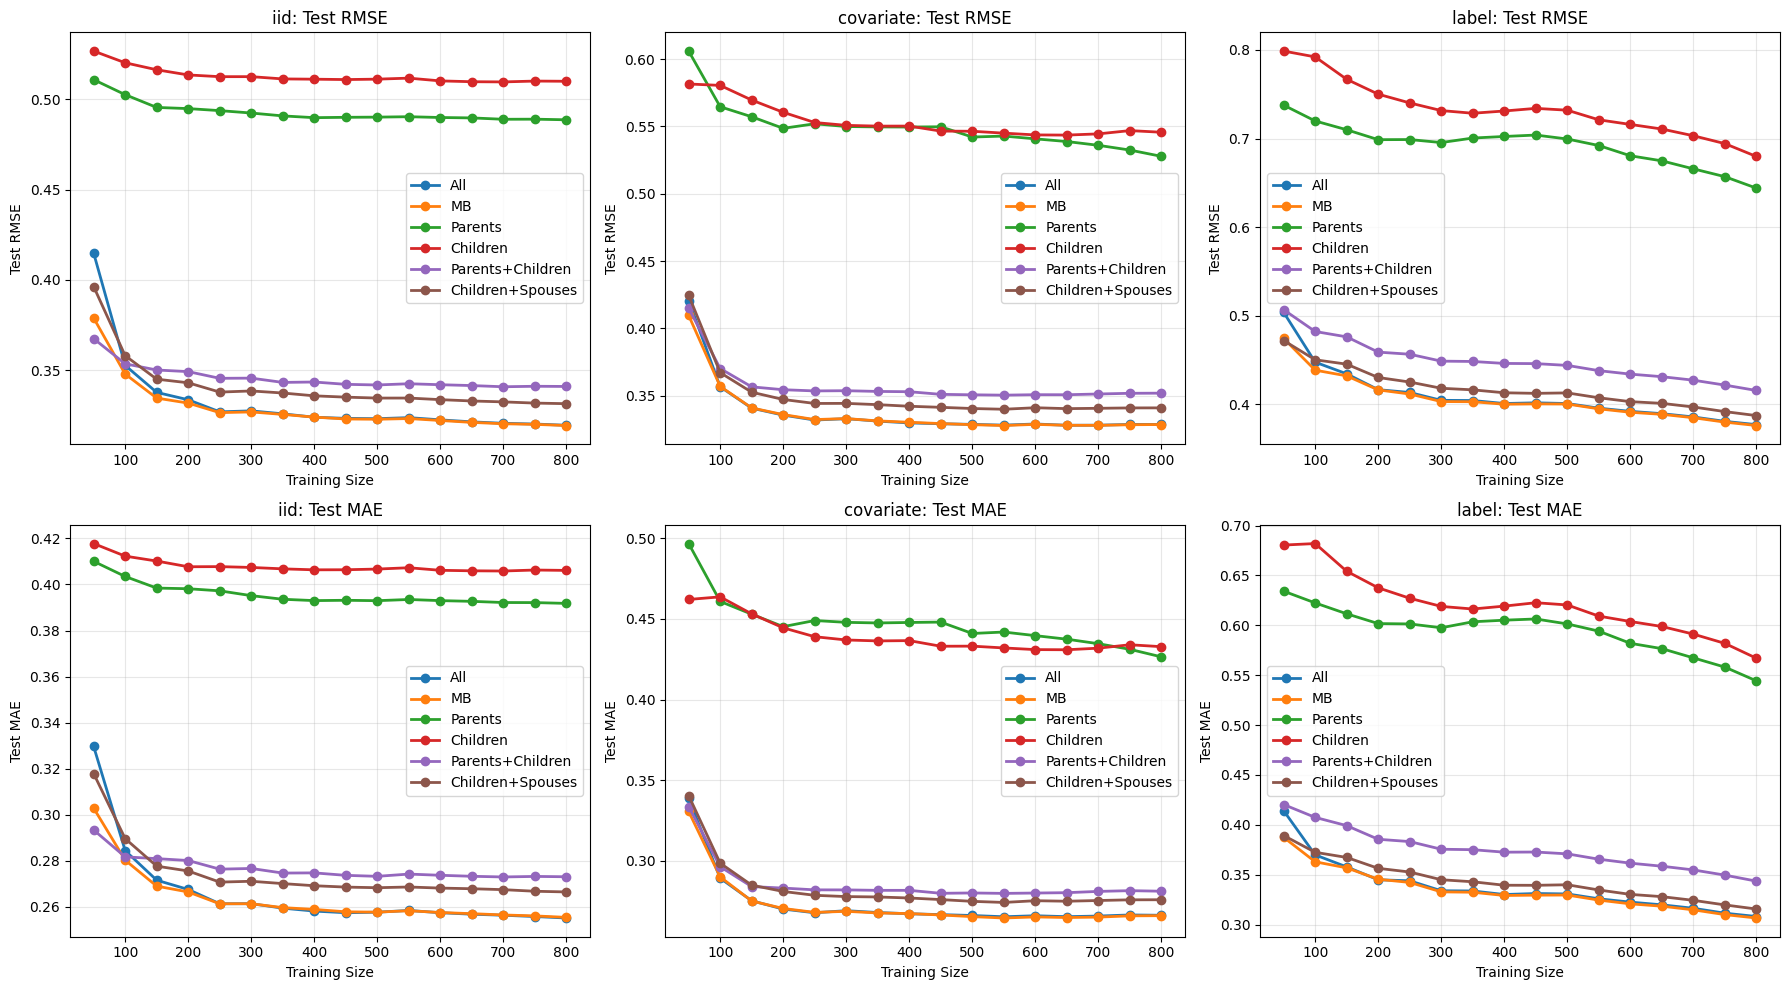

In [18]:
# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, env_name in enumerate(['iid', 'covariate', 'label']):
    env_results = summary_df[summary_df['Environment'] == env_name]

    # Plot RMSE
    for fs_name in ['All', 'MB', 'Parents', 'Children', 'Parents+Children', 'Children+Spouses']:
        fs_results = env_results[env_results['Feature Set'] == fs_name]
        axes[0, i].plot(fs_results['Train Size'], fs_results['RMSE'],
                       marker='o', label=fs_name, linewidth=2)

    axes[0, i].set_xlabel('Training Size')
    axes[0, i].set_ylabel('Test RMSE')
    axes[0, i].set_title(f'{env_name}: Test RMSE')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)

    # Plot MAE
    for fs_name in ['All', 'MB', 'Parents', 'Children', 'Parents+Children', 'Children+Spouses']:
        fs_results = env_results[env_results['Feature Set'] == fs_name]
        axes[1, i].plot(fs_results['Train Size'], fs_results['MAE'],
                       marker='o', label=fs_name, linewidth=2)

    axes[1, i].set_xlabel('Training Size')
    axes[1, i].set_ylabel('Test MAE')
    axes[1, i].set_title(f'{env_name}: Test MAE')
    axes[1, i].legend()
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Key findings

1. MB is still the optimal feature set in OOD settings (at least covariate shift + label shift)
2. Parents and Children alone perform significantly worse than other feature sets. This is aligned with results in Nastl et. al
3. MB has significant lead when training size (<100) is limited, the gap diminishes as training size grows.
4. Due to the small graph size (node < 50) and relative large density, MB is often close to all features, making the difference less evident.

### References:

Nastl, Vivian, and Moritz Hardt. "Do causal predictors generalize better to new domains?." Advances in Neural Information Processing Systems 37 (2024): 31202-31315.

## Bonus Point (5 Points)

1. Is MB still optimal for nonlinear functionals? 

```python
example_meta = metadata_ds.filter(lambda x: sum(x['parents']) > 0 and sum(x['children']) > 0 and x['scm']['functional'] == 'nonlinear' and sum(x['feature_mask']) < x['n_features'])
```


=== Bonus: Testing MB with Nonlinear Functionals ===
Found 21 nonlinear datasets.
  Loaded nonlinear dataset: covariate-nl-0
  Loaded nonlinear dataset: covariate-nl-1
  Loaded nonlinear dataset: iid-nl-2
  Loaded nonlinear dataset: label-nl-3
  Loaded nonlinear dataset: covariate-nl-4


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

  Loaded nonlinear dataset: iid-nl-5


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

  Loaded nonlinear dataset: label-nl-6


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

  Loaded nonlinear dataset: iid-nl-7


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

  Loaded nonlinear dataset: iid-nl-8


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

  Loaded nonlinear dataset: iid-nl-9


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

  Loaded nonlinear dataset: label-nl-10


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

  Loaded nonlinear dataset: label-nl-11


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

  Loaded nonlinear dataset: covariate-nl-12


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

  Loaded nonlinear dataset: covariate-nl-13


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

  Loaded nonlinear dataset: iid-nl-14


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

  Loaded nonlinear dataset: label-nl-15


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

  Loaded nonlinear dataset: label-nl-16


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

  Loaded nonlinear dataset: covariate-nl-17


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

  Loaded nonlinear dataset: covariate-nl-18


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

  Loaded nonlinear dataset: label-nl-19


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

  Loaded nonlinear dataset: iid-nl-20

Evaluating covariate-nl-0...

Evaluating covariate-nl-1...

Evaluating iid-nl-2...

Evaluating label-nl-3...

Evaluating covariate-nl-4...

Evaluating iid-nl-5...

Evaluating label-nl-6...

Evaluating iid-nl-7...

Evaluating iid-nl-8...

Evaluating iid-nl-9...

Evaluating label-nl-10...

Evaluating label-nl-11...

Evaluating covariate-nl-12...

Evaluating covariate-nl-13...

Evaluating iid-nl-14...

Evaluating label-nl-15...

Evaluating label-nl-16...

Evaluating covariate-nl-17...

Evaluating covariate-nl-18...

Evaluating label-nl-19...

Evaluating iid-nl-20...


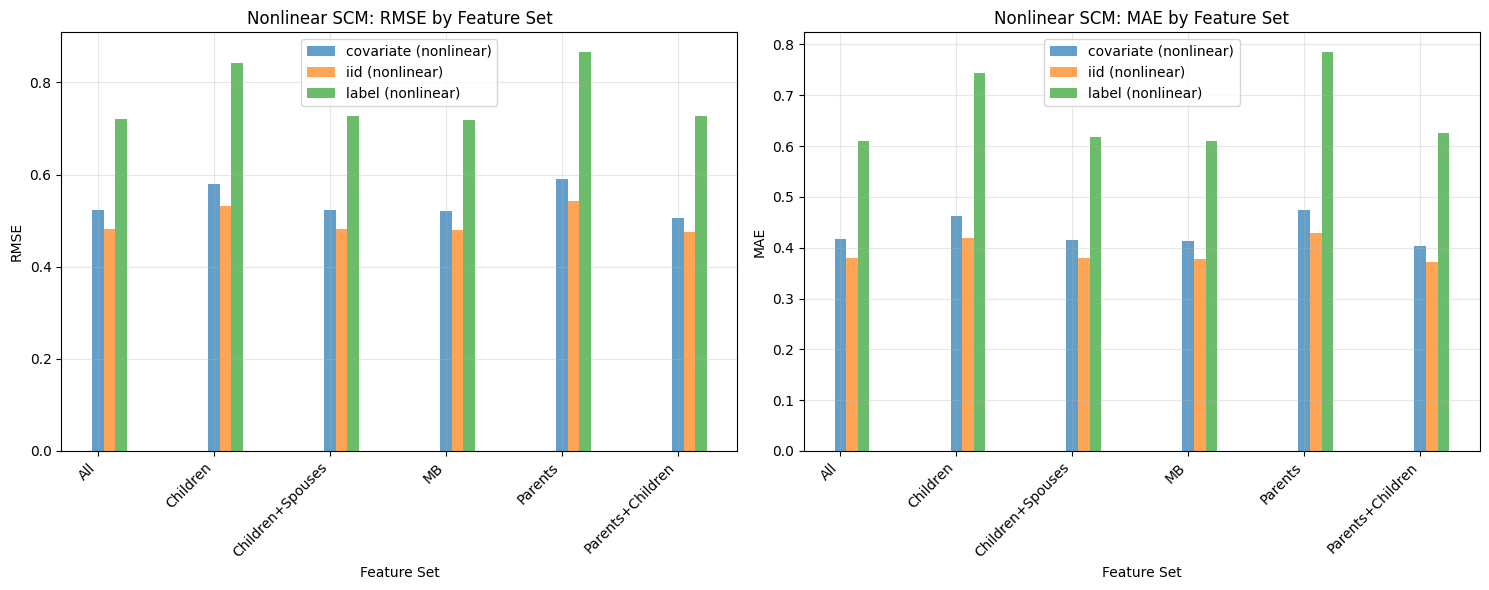


=== Nonlinear SCM Results Summary ===

COVARIATE Environment (Nonlinear):
  Best RMSE: Parents+Children (0.5060)
  Best MAE: Parents+Children (0.4036)
  MB Performance: RMSE=0.5200, MAE=0.4128
  MB is optimal: False

IID Environment (Nonlinear):
  Best RMSE: Parents+Children (0.4756)
  Best MAE: Parents+Children (0.3721)
  MB Performance: RMSE=0.4788, MAE=0.3774
  MB is optimal: False

LABEL Environment (Nonlinear):
  Best RMSE: MB (0.7193)
  Best MAE: MB (0.6092)
  MB Performance: RMSE=0.7193, MAE=0.6092
  MB is optimal: True


In [21]:
print("\n=== Bonus: Testing MB with Nonlinear Functionals ===")

# Load nonlinear datasets
nonlinear_datasets = {}
example_meta_nl = metadata_ds.filter(lambda x: sum(x['parents']) > 0 and sum(x['children']) > 0 and x['scm']['functional'] == 'nonlinear' and sum(x['feature_mask']) < x['n_features'])

if len(example_meta_nl) == 0:
    print("No nonlinear datasets found with the specified criteria.")
else:
    print(f"Found {len(example_meta_nl)} nonlinear datasets.")

    for idx, data_id in enumerate(example_meta_nl['data_id']):  
        try:
            X_tr, y_tr, X_te, y_te, meta = load_data(path_to_data, data_id=data_id, include_metadata=True)
            shift = meta['environment']['method']
            key = f"{shift}-nl-{idx}"
            nonlinear_datasets[key] = {
                'X_train': X_tr, 'y_train': y_tr,
                'X_test': X_te, 'y_test': y_te,
                'metadata': meta
            }
            print(f"  Loaded nonlinear dataset: {key}")
        except Exception as e:
            print(f"  Error loading nonlinear dataset {data_id}: {e}")

    # Evaluate nonlinear datasets
    nonlinear_results = []

    for env_name, data in nonlinear_datasets.items():
        print(f"\nEvaluating {env_name}...")

        adj_matrix = np.asarray(data['metadata']['adjacency_matrix'])

        X_train_full = data['X_train']
        y_train_full = data['y_train']
        X_test = data['X_test']
        y_test = data['y_test']

        # Test with different training sizes
        for train_size in [100, 200, 500]:  # Fewer sizes for nonlinear to save time
            X_train = X_train_full[:train_size]
            y_train = y_train_full[:train_size]

            # Get feature sets
            feature_sets = get_feature_sets(adj_matrix)

            # Evaluate each feature set
            for fs_name, fs_mask in feature_sets.items():
                try:
                    metrics = evaluate_feature_set(X_train, y_train, X_test, y_test, fs_mask)

                    nonlinear_results.append({
                        'id': env_name,
                        'Environment': env_name.split('-')[0],
                        'Functional': 'nonlinear',
                        'Train Size': train_size,
                        'Feature Set': fs_name,
                        'RMSE': metrics['rmse'],
                        'MAE': metrics['mae'],
                        'STD': metrics['std'],
                        'N Features': int(np.sum(fs_mask))
                    })
                except Exception as e:
                    print(f"  Error evaluating {fs_name}: {e}")

    if nonlinear_results:
        nonlinear_df = pd.DataFrame(nonlinear_results)

        # Create comparison plot
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Aggregate results by environment and feature set
        summary_nl = nonlinear_df.groupby(['Environment', 'Feature Set']).agg({
            'RMSE': 'mean',
            'MAE': 'mean',
            'N Features': 'mean'
        }).reset_index()

        # Plot RMSE comparison
        env_types = summary_nl['Environment'].unique()
        for i, env in enumerate(env_types):
            env_data = summary_nl[summary_nl['Environment'] == env]
            axes[0].bar([x + i*0.1 for x in range(len(env_data['Feature Set']))],
                       env_data['RMSE'], width=0.1, label=f'{env} (nonlinear)', alpha=0.7)

        axes[0].set_xlabel('Feature Set')
        axes[0].set_ylabel('RMSE')
        axes[0].set_title('Nonlinear SCM: RMSE by Feature Set')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Plot MAE comparison
        for i, env in enumerate(env_types):
            env_data = summary_nl[summary_nl['Environment'] == env]
            axes[1].bar([x + i*0.1 for x in range(len(env_data['Feature Set']))],
                       env_data['MAE'], width=0.1, label=f'{env} (nonlinear)', alpha=0.7)

        axes[1].set_xlabel('Feature Set')
        axes[1].set_ylabel('MAE')
        axes[1].set_title('Nonlinear SCM: MAE by Feature Set')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        # Set x-tick labels
        axes[0].set_xticks(range(len(env_data['Feature Set'])))
        axes[0].set_xticklabels(env_data['Feature Set'], rotation=45, ha='right')
        axes[1].set_xticks(range(len(env_data['Feature Set'])))
        axes[1].set_xticklabels(env_data['Feature Set'], rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print("\n=== Nonlinear SCM Results Summary ===")
        for env in env_types:
            print(f"\n{env.upper()} Environment (Nonlinear):")
            env_data = summary_nl[summary_nl['Environment'] == env]
            best_rmse = env_data.loc[env_data['RMSE'].idxmin()]
            best_mae = env_data.loc[env_data['MAE'].idxmin()]
            print(f"  Best RMSE: {best_rmse['Feature Set']} ({best_rmse['RMSE']:.4f})")
            print(f"  Best MAE: {best_mae['Feature Set']} ({best_mae['MAE']:.4f})")

            # Check if MB is optimal
            mb_row = env_data[env_data['Feature Set'] == 'MB']
            if len(mb_row) > 0:
                mb_rmse = mb_row['RMSE'].iloc[0]
                mb_mae = mb_row['MAE'].iloc[0]
                print(f"  MB Performance: RMSE={mb_rmse:.4f}, MAE={mb_mae:.4f}")
                print(f"  MB is optimal: {mb_rmse == best_rmse['RMSE'] and mb_mae == best_mae['MAE']}")

    else:
        print("ERROR: No nonlinear results to display.")

### Observation:
1. Is MB still optimal for nonlinear functionals?
 
Ans: Looking at the analysis, not always.